In [ ]:
! pip install pystan

In [ ]:
import numpy as np
import stan
import arviz as az
import nest_asyncio

In [ ]:
# Paramètres
n = 1000
phi0 = 0.7  # Paramètre AR(1) pour X
sigma0_sq = 0.3
beta = 1 / np.sqrt(5 * np.pi)

# Données simulées
np.random.seed(102)
xi = np.random.normal(0, 1, n)
eta = np.random.normal(0, np.sqrt(sigma0_sq), n)
X = np.zeros(n)
X[0] = np.random.normal(0, np.sqrt(sigma0_sq / (1 - phi0**2)))
for i in range(1, n):
    X[i] = phi0 * X[i-1] + eta[i]
Y = X + beta * np.log(xi**2) - beta * np.mean(np.log(xi**2))

nest_asyncio.apply()  # Permet d'exécuter asyncio dans Jupyter/Colab

In [ ]:
stan_model_code = """
data {
    int<lower=1> n;          // Nombre d'observations
    vector[n] Y;             // Observations
    real<lower=0> beta;
}
parameters {
    real<lower=-0.9> phi;  // Coefficient AR
    real<lower=0> sigma_sq;           // Variance du bruit
    array[n] real X;                  // Processus latent X
}
model {
    // Priors
    phi ~ uniform(-0.9, 0.9);
    sigma_sq ~ uniform(0, 1);
    X[1] ~ normal(0, sqrt(sigma_sq)); // Initialisation

    // Processus AR
    for (i in 2:n) {
        X[i] ~ normal(phi * X[i-1], sqrt(sigma_sq));
    }

    // Observations
    Y ~ normal(X, sqrt(0.5 *(beta^2)* pi()^2));
}
"""

# Compilation du modèle
posterior = stan.build(stan_model_code, data={"n": len(Y), "Y": Y, "beta": beta})

Building...



Building: 40.1s, done.Messages from stanc:


In [ ]:
# Échantillonnage
fit = posterior.sample(num_chains=3, num_samples=5000, num_warmup = 1000)

Sampling:   0%

ValueError: {'json': {'algorithm': ['Unknown field.']}}

In [ ]:
# Convertir le fit de PyStan en objet ArviZ
idata = az.from_pystan(fit)

In [ ]:
# Afficher les statistiques résumées
az.summary(idata, var_names=["phi", "sigma_sq"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,0.721,0.035,0.656,0.786,0.001,0.0,2673.0,5274.0,1.0
sigma_sq,0.225,0.027,0.176,0.278,0.001,0.0,1663.0,3008.0,1.0


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma_sq'}>,
        <Axes: title={'center': 'sigma_sq'}>]], dtype=object)

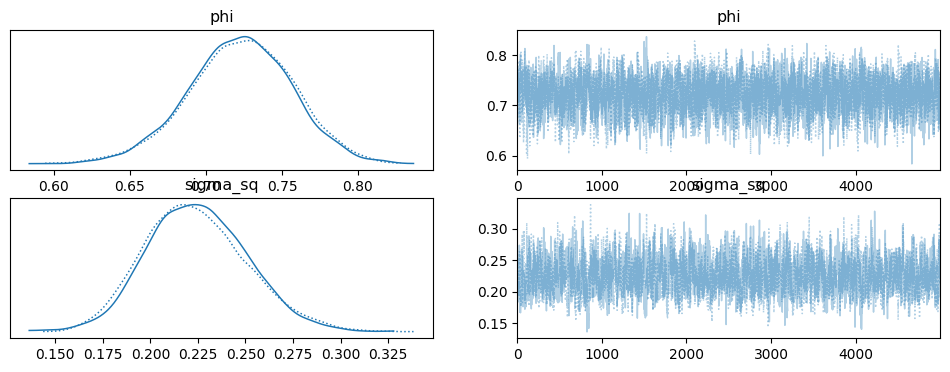

In [ ]:
# Tracé des résultats
az.plot_trace(idata, var_names=["phi", "sigma_sq"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

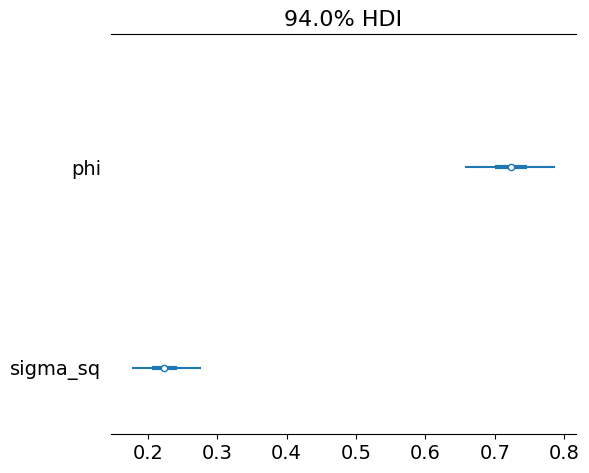

In [ ]:
# Vérification de la convergence avec le critère de Gelman-Rubin
az.plot_forest(idata, var_names=["phi", "sigma_sq"], combined=True)

array([<Axes: title={'center': 'phi\n0'}>,
       <Axes: title={'center': 'phi\n1'}>,
       <Axes: title={'center': 'sigma_sq\n0'}>,
       <Axes: title={'center': 'sigma_sq\n1'}>], dtype=object)

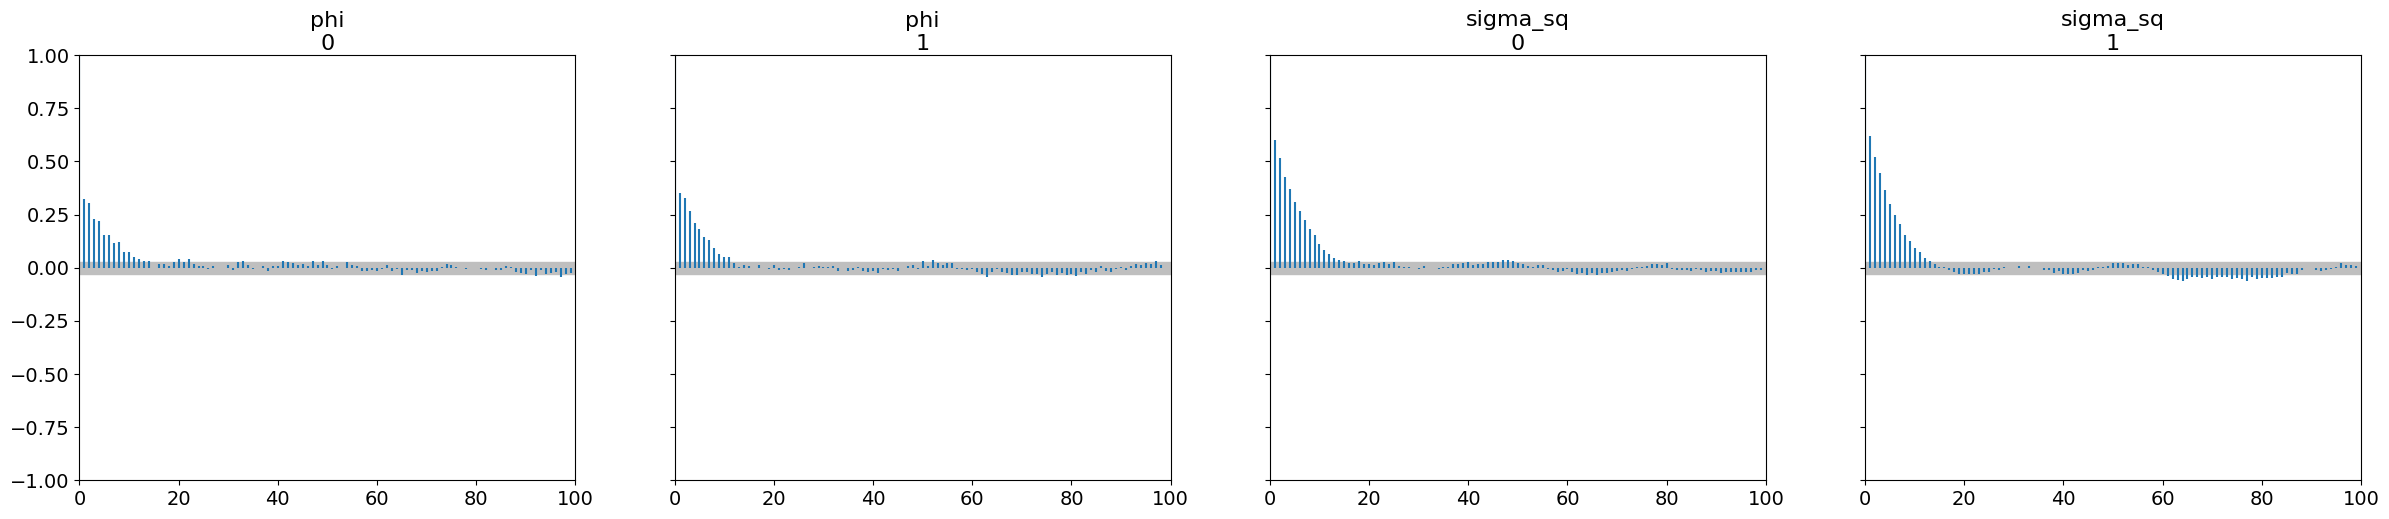

In [ ]:
# Autocorrélation
az.plot_autocorr(idata, var_names=["phi", "sigma_sq"])

In [ ]:
# Effective Sample Size (ESS)
ess = az.ess(idata)
print(ess)

<xarray.Dataset> Size: 16kB
Dimensions:   (X_dim_0: 1000)
Coordinates:
  * X_dim_0   (X_dim_0) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    X         (X_dim_0) float64 8kB 1.662e+04 1.569e+04 ... 1.486e+04 1.501e+04
    phi       float64 8B 1.948e+03
    sigma_sq  float64 8B 1.271e+03


array([<Axes: title={'center': 'phi'}>,
       <Axes: title={'center': 'sigma_sq'}>], dtype=object)

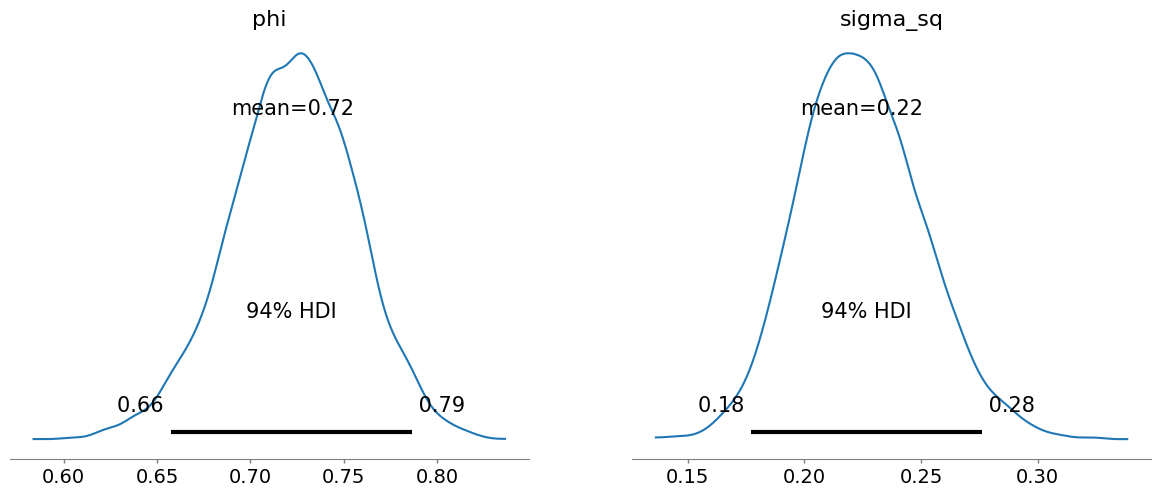

In [ ]:
# Afficher la distribution des paramètres
az.plot_posterior(idata, var_names=["phi", "sigma_sq"])

array([[<Axes: title={'center': 'phi'}>,
        <Axes: title={'center': 'sigma_sq'}>]], dtype=object)

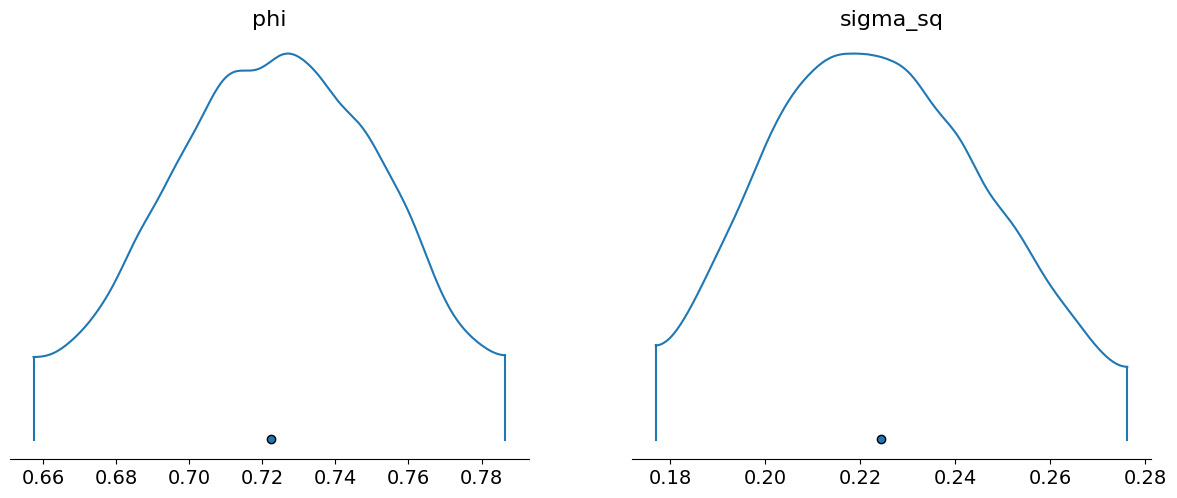

In [ ]:
# Vérifier la densité des paramètres
az.plot_density(idata, var_names=["phi", "sigma_sq"])


array([<Axes: title={'center': 'phi'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma_sq'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

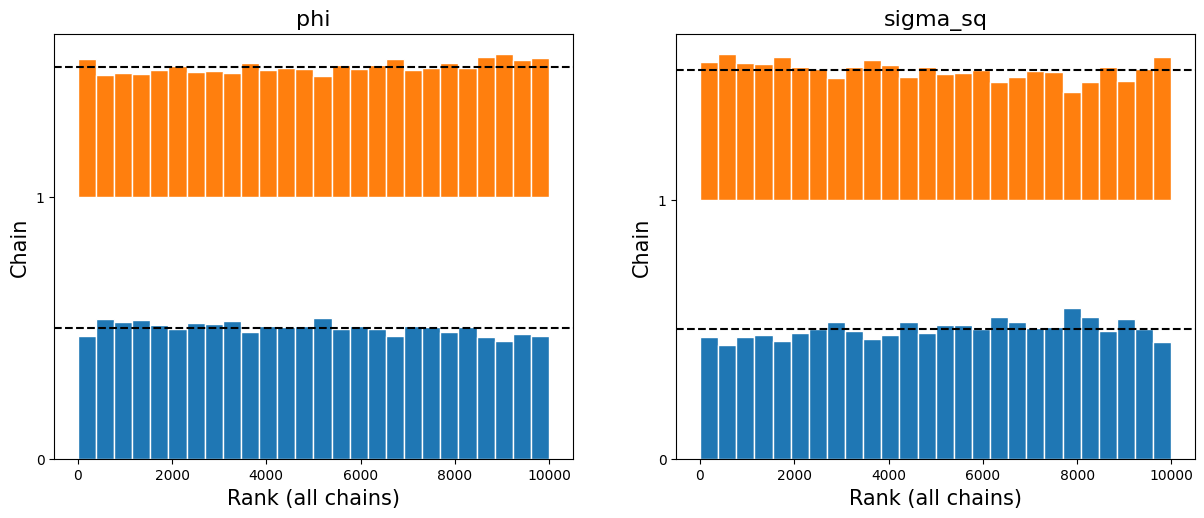

In [ ]:
# Vérifier la convergence (R-hat)
az.plot_rank(idata, var_names=["phi", "sigma_sq"])

In [ ]:
import asyncio
import dataclasses
import json
import re
import time
from typing import Dict, List, Optional, Sequence, Tuple, Union, cast

import httpstan.models
import httpstan.schemas
import httpstan.services.arguments as arguments
import httpstan.utils
import numpy as np
import simdjson
from clikit.io import ConsoleIO

import stan.common
import stan.fit
import stan.plugins


Data = Dict[str, Union[int, float, Sequence[Union[int, float]]]]

@dataclasses.dataclass(frozen=True)
class Model:

    model_name: str
    program_code: str
    data: Data
    param_names: Tuple[str, ...]
    random_seed: Optional[int]

    def __post_init__(self):
        if self.model_name != httpstan.models.calculate_model_name(self.program_code):
            raise ValueError("_")


